In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dismech
import csv
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting

np.concat = np.concatenate
np.bool = np.bool_

geom = dismech.GeomParams(rod_r0=0,
                          shell_h=1e-3)

material = dismech.Material(density=1200,
                            youngs_rod=0,
                            youngs_shell=2e6,
                            poisson_rod=0,
                            poisson_shell=0.5)

static_3d_sim = dismech.SimParams(static_sim=True,
                                  two_d_sim=False,
                                  use_mid_edge=False,
                                  use_line_search=False,
                                  show_floor=False,
                                  log_data=True,
                                  log_step=1,
                                  dt=1e-1,
                                  max_iter=25,
                                  total_time=1,
                                  plot_step=10,
                                  tol=1e-4,
                                  ftol=1e-4,
                                  dtol=1e-2)

env = dismech.Environment()
env.add_force('gravity', g=np.array([0.0, 0.0, 0.0]))

# geo = dismech.Geometry.from_txt('four_corner.txt')
geo = dismech.Geometry.from_txt('mesh_python_example1.txt')

# robot = dismech.SoftRobot(geom, material, geo, static_3d_sim, env)

# Create a robot instance (w/o gravity)
base_robot = dismech.SoftRobot(geom, material, geo, static_3d_sim, dismech.Environment())


In [2]:
# Output connectivity matrix

# def write_edge_map(robot, filename):
#     headers = ["EdgeID", "N1", "N2"]
#     with open(filename, mode="w", newline="") as file:
#         writer = csv.writer(file)
#         writer.writerow(headers)
#         for i, (n1, n2) in enumerate(robot._SoftRobot__edges):
#             writer.writerow([i, n1, n2])

# write_edge_map(robot, filename="connectivity.csv")

# # ### Energy

# # set strain_bar
# #  instance    = package.class        (instance.object(list type), instance.instance)
# stretch_energy = dismech.StretchEnergy(robot.stretch_springs, robot.state)

# # FIXME: Mid-edge breaks for this!!
# if robot.sim_params.use_mid_edge:
#     shell_energy = dismech.TriangleEnergy(robot.triangle_springs, robot.state)
# else:
#     shell_energy = dismech.HingeEnergy(robot.hinge_springs, robot.state)

In [3]:
# ### Energy

# set strain_bar
#  instance    = package.class        (instance.object(list type), instance.instance)
stretch_energy = dismech.StretchEnergy(base_robot.stretch_springs, base_robot.state)

# FIXME: Mid-edge breaks for this!!
if base_robot.sim_params.use_mid_edge:
    shell_energy = dismech.TriangleEnergy(base_robot.triangle_springs, base_robot.state)
else:
    shell_energy = dismech.HingeEnergy(base_robot.hinge_springs, base_robot.state)

In [4]:

def write_elastic_energy_csv(data, filename="elastic_energy_total.csv", fill_value=None):
    """
    Writes a list of nested dictionaries to a CSV file with elastic energy data.

    Parameters:
    - data (list of dicts): List where each dict maps energy types to edge data.
    - filename (str): The CSV filename.
    - fill_value (float or str): Value to fill missing entries (default: None).
    """
    # Collect all unique energy types and edge IDs
    energy_types = set()
    edge_ids = set()

    for entry in data:
        for energy_type, edges in entry.items():
            energy_types.add(energy_type)
            edge_ids.update(edges.keys())

    energy_types = sorted(energy_types)  # Sort for consistent column order
    edge_ids = sorted(edge_ids)

    print("Energy Types:", energy_types)
    print("Edge IDs:", edge_ids)

    # Define CSV headers and add two extra columns for totals
    headers = ["Index", "EdgeID"]
    for et in energy_types:
        headers.extend([f"{et}Strain", f"{et}Energy"])
    headers.extend(["TotalHingeEnergy", "TotalStretchEnergy"])

    # Write to CSV
    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        for idx, entry in enumerate(data):
            # Compute total energies for this entry
            total_hinge = sum(
                energy for (strain, energy) in entry.get("Hinge", {}).values()
                if isinstance(energy, (int, float))
            )
            total_stretch = sum(
                energy for (strain, energy) in entry.get("Stretch", {}).values()
                if isinstance(energy, (int, float))
            )
            for edge_id in edge_ids:
                row = [idx, edge_id]
                for et in energy_types:
                    # Look up the (strain, energy) for the current edge and energy type.
                    strain, energy = entry.get(et, {}).get(edge_id, (fill_value, fill_value))
                    row.extend([strain, energy])
                # Append the total energies to the row.
                row.extend([total_hinge, total_stretch])
                writer.writerow(row)
                
def get_entry(state, springs, energy, nodes_to_edge_id):
    ret = {}
    strain = energy.get_strain(state)
    energy_arr = energy.get_energy_linear_elastic(state, False)
    for i, spring in enumerate(springs):
        # Both hinge and stretch first 2 nodes are around main edge
        edge_id = nodes_to_edge_id(spring.nodes_ind[:2])
        ret[int(edge_id)] = (strain[i], energy_arr[i][0])
    return ret

# def get_node_to_edge_id(robot):
#     def helper(edge):
#         a, b = edge
#         match = np.where((robot._SoftRobot__edges == [a, b]).all(
#             axis=1) | (robot._SoftRobot__edges == [b, a]).all(axis=1))[0]
#         return match[0] if match.size > 0 else None
#     return helper

# n_to_e = get_node_to_edge_id(robot)

def get_node_to_edge_id(robot):
    def helper(edge):
        a, b = edge
        match = np.where((robot._SoftRobot__edges == [a, b]).all(
            axis=1) | (robot._SoftRobot__edges == [b, a]).all(axis=1))[0]
        return match[0] if match.size > 0 else None
    return helper

n_to_e = get_node_to_edge_id(base_robot)


New shape: (27, 3)
Number of nodes: 27
Number of edges: 62


C:\Users\zhang\AppData\Local\Temp\ipykernel_12588\2125714203.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


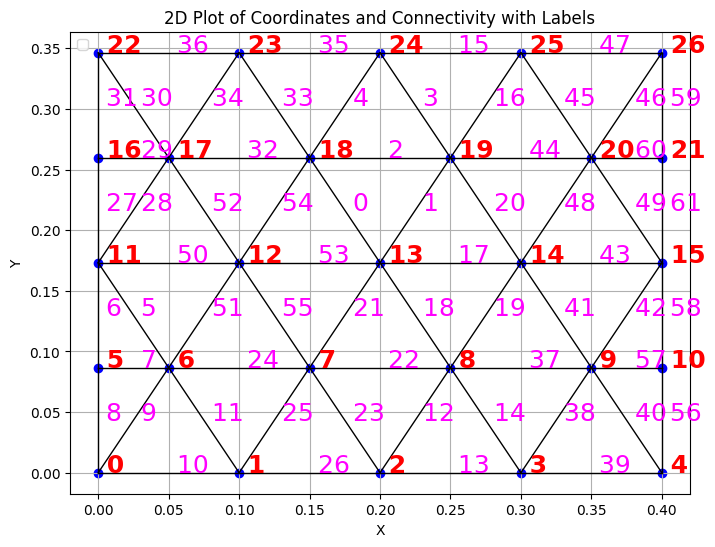

C:\Users\zhang\AppData\Local\Temp\ipykernel_12588\2125714203.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


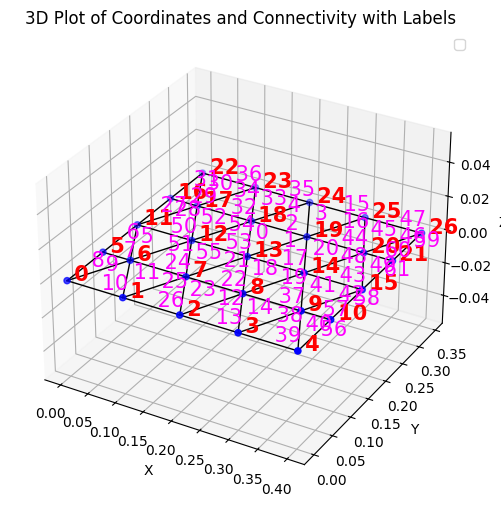

In [5]:
# Plot the original system

# Reshape node coordinates
q0_original = base_robot.q0                 # q0_original: a 1D array. (81,) for example1
coordinates = q0_original.reshape((-1, 3))  # Reshape into (27, 3), each row is [x, y, z]
print("New shape:", coordinates.shape)
# print("Coordinates:\n", coordinates)

# Get connectivity matrix from the robot
edges = base_robot._SoftRobot__edges
# print("edges", edges)

num_nodes = coordinates.shape[0]
num_edges = len(edges)
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)


# 2D Plot with connectivity
plt.figure(figsize=(8,6))
plt.scatter(coordinates[:, 0], coordinates[:, 1], c='blue', marker='o')

# Label each node with its ID (using zero-based indexing)
for i, (x, y, _) in enumerate(coordinates):
    plt.text(x, y, f' {i}', color='red', fontsize=18, fontweight='bold')

# Draw each edge as a line between nodes (using x and y coordinates)
for edge_id, (n1, n2) in enumerate(edges):
    x_coords = [coordinates[n1, 0], coordinates[n2, 0]]
    y_coords = [coordinates[n1, 1], coordinates[n2, 1]]
    plt.plot(x_coords, y_coords, 'k-', linewidth=1)
    
    # Compute the midpoint for labeling the edge
    mid_x = (x_coords[0] + x_coords[1]) / 2
    mid_y = (y_coords[0] + y_coords[1]) / 2
    plt.text(mid_x, mid_y, f' {edge_id}', color='magenta', fontsize=18)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Plot of Coordinates and Connectivity with Labels')
plt.legend()
plt.grid(True)
plt.show()

# 3D Plot with connectivity
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2],
           c='blue', marker='o')

# Label each node in 3D with its ID
for i, (x, y, z) in enumerate(coordinates):
    ax.text(x, y, z, f' {i}', color='red', fontsize=15, fontweight='bold')

# Draw each edge in 3D (using x, y, and z coordinates)
for edge_id, (n1, n2) in enumerate(edges):
    x_coords = [coordinates[n1, 0], coordinates[n2, 0]]
    y_coords = [coordinates[n1, 1], coordinates[n2, 1]]
    z_coords = [coordinates[n1, 2], coordinates[n2, 2]]
    ax.plot(x_coords, y_coords, z_coords, 'k-', linewidth=1)
    
    # Compute the midpoint for labeling the edge in 3D
    mid_x = (x_coords[0] + x_coords[1]) / 2
    mid_y = (y_coords[0] + y_coords[1]) / 2
    mid_z = (z_coords[0] + z_coords[1]) / 2
    ax.text(mid_x, mid_y, mid_z, f' {edge_id}', color='magenta', fontsize=15)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot of Coordinates and Connectivity with Labels')
plt.legend()
plt.show()


In [6]:
# BCs depend on ref coordinates from q0_original
 
print(coordinates.shape)

# coordinates is a (num_nodes, 3) numpy array, each row is [x, y, z]
tol = 1e-5

min_x = np.min(coordinates[:, 0])
max_x = np.max(coordinates[:, 0])
min_y = np.min(coordinates[:, 1])
max_y = np.max(coordinates[:, 1])

lengthx=max_x-min_x
lengthy=max_y-min_y
print("length x:", lengthx)
print("length y:", lengthy)


left_ids   = np.array(np.where(np.isclose(coordinates[:, 0], min_x, atol=tol))[0])
right_ids  = np.array(np.where(np.isclose(coordinates[:, 0], max_x, atol=tol))[0])
bottom_ids = np.where(np.isclose(coordinates[:, 1], min_y, atol=tol))[0]
top_ids    = np.where(np.isclose(coordinates[:, 1], max_y, atol=tol))[0]

print("Left boundary node IDs:", left_ids)
print("Right boundary node IDs:", right_ids)
print("Bottom boundary node IDs:", bottom_ids)
print("Top boundary node IDs:", top_ids)

# base_robot = base_robot.fix_nodes(left_ids)
# base_robot = base_robot.fix_nodes(right_ids)

# print("Fixed node IDs:", base_robot.fixed_nodes)
base_robot = base_robot.fix_nodes(np.union1d(left_ids, right_ids))

BCx=lengthx*0.2
lin = np.linspace(0, BCx, 5)

# a list of positions, each as [x, y, z]
Loadsteps = [np.array([val, 0, 0]) for val in lin]

for i, pos in enumerate(Loadsteps):
    print(f"Loadsteps2: {pos}")

print(BCx)
print(lin)
print(Loadsteps)


(27, 3)
length x: 0.4
length y: 0.34641
Left boundary node IDs: [ 0  5 11 16 22]
Right boundary node IDs: [ 4 10 15 21 26]
Bottom boundary node IDs: [0 1 2 3 4]
Top boundary node IDs: [22 23 24 25 26]
Loadsteps2: [0. 0. 0.]
Loadsteps2: [0.02 0.   0.  ]
Loadsteps2: [0.04 0.   0.  ]
Loadsteps2: [0.06 0.   0.  ]
Loadsteps2: [0.08 0.   0.  ]
0.08000000000000002
[0.   0.02 0.04 0.06 0.08]
[array([0., 0., 0.]), array([0.02, 0.  , 0.  ]), array([0.04, 0.  , 0.  ]), array([0.06, 0.  , 0.  ]), array([0.08, 0.  , 0.  ])]


In [7]:
# Create two lists of edge IDs.

def get_edges_right(edges, coords, threshold=0.3):
    #    Return a list of edge IDs
    edge_ids_above = []
    for edge_id, (n1, n2) in enumerate(edges):
        x1, x2 = coords[n1, 0], coords[n2, 0]
        # Compute midpoint x
        mx = (x1 + x2) / 2.0
        if mx > threshold:
            edge_ids_above.append(edge_id)
    return edge_ids_above

def get_edges_top(edges, coords, threshold=0.2):
    edge_ids_above = []
    for edge_id, (n1, n2) in enumerate(edges):
        y1, y2 = coords[n1, 1], coords[n2, 1]
        # Compute midpoint x
        my = (y1 + y2) / 2.0
        if my > threshold:
            edge_ids_above.append(edge_id)
    return edge_ids_above


threshold_value = 0.3
edges_right = get_edges_right(edges, coordinates, threshold=threshold_value)
# print(f"Edge IDs with midpoint x > {threshold_value}:", edges_right)

threshold_value = 0.2
edges_top = get_edges_top(edges, coordinates, threshold=threshold_value)
# print(f"Edge IDs with midpoint y > {threshold_value}:", edges_top)

'''
# 2. You can also just set strain
custom_stretch_energy.set_nat_strain(np.zeros_like(custom_stretch_energy._nat_strain))
# print(custom_stretch_energy._nat_strain)

# helper to get edgeID of hinge springs

def get_edge_id_hinge_springs(hinge_springs):
    return np.stack([n_to_e(s.nodes_ind[:2]) for s in hinge_springs])

# print(get_edge_id_hinge_springs(robot.hinge_springs))
'''

'\n# 2. You can also just set strain\ncustom_stretch_energy.set_nat_strain(np.zeros_like(custom_stretch_energy._nat_strain))\n# print(custom_stretch_energy._nat_strain)\n\n# helper to get edgeID of hinge springs\n\ndef get_edge_id_hinge_springs(hinge_springs):\n    return np.stack([n_to_e(s.nodes_ind[:2]) for s in hinge_springs])\n\n# print(get_edge_id_hinge_springs(robot.hinge_springs))\n'

In [8]:
# test 04-14-25

robot_test = dismech.SoftRobot(geom, material, geo, static_3d_sim, dismech.Environment())
robot_test = robot_test.fix_nodes(left_ids)

def both_thresh_strain(strain: float, x_thresh: float = 0.3, y_thresh: float = 0.2):
    """
    Sets all stretch springs where x_mid > 0.3 or y_mid > 0.2 to strain.
    If any value of the strain array is nan, it will be replaced with the normal strain calculation.
    """
    def func(nodes):
        n1, n2 = nodes
        ret = np.full(n1.shape[0], np.nan)
        
        mx = (n1[:, 0] + n2[:,0]) / 2
        my = (n1[:, 1] + n2[:,1]) / 2

        ret[mx > x_thresh] = strain
        # ret[my > y_thresh] = strain

        return ret
    return func

# For hinges, there are 4 nodes, but the main edge is the first two nodes
def hinge_thresh_strain(strain: float, x_thresh: float = 0.3, y_thresh: float = 0.2):
    """
    Sets all hinge springs where x_mid > 0.3 or y_mid > 0.2 to strain
    """
    def func(nodes):
        n1, n2, _, _ = nodes
        ret = np.full(n1.shape[0], np.nan)
        
        mx = (n1[:, 0] + n2[:,0]) / 2
        my = (n1[:, 1] + n2[:,1]) / 2

        ret[mx > x_thresh] = strain
        # ret[my > y_thresh] = strain

        return ret
    return func

custom_stretch_energy = dismech.StretchEnergy(robot_test.stretch_springs, robot_test.state, both_thresh_strain(2.0))
print("Edge IDs with ref stretch strain: {}".format(np.where(custom_stretch_energy._nat_strain == 2.0)))
print("ref stretch strains: {}".format(custom_stretch_energy._nat_strain))

custom_hinge_energy = dismech.HingeEnergy(robot_test.hinge_springs, robot_test.state, hinge_thresh_strain(100.0))
print("ref hinge strains: {}".format(custom_hinge_energy._nat_strain))

hinge_id_list = []
for i in np.where(custom_hinge_energy._nat_strain == 100.0)[0]:
    hinge_id_list.append(int(n_to_e(robot_test.hinge_springs[i].nodes_ind[:2])))
print("Edge IDs with ref hinge strain: {}".format(hinge_id_list))


stepper = dismech.ImplicitEulerTimeStepper(robot_test)
# stepper.before_step = pull_right_end

robots = stepper.simulate()

qs = np.stack([robot.state.q for robot in robots])

# Save states instead of q.
states = [robot.state for robot in robots]

data = []
for state in states:
    temp = {}
    temp['Stretch'] = get_entry(state, robot_test.stretch_springs, custom_stretch_energy, n_to_e)
    temp['Hinge'] = get_entry(state, robot_test.hinge_springs, custom_hinge_energy, n_to_e)
    data.append(temp)

write_elastic_energy_csv(data, filename='example1_strain_energy.csv', fill_value="-1E10")

t = np.arange(robot_test.sim_params.total_time, step=robot_test.sim_params.dt)
options = dismech.AnimationOptions(y_lim=[-0.1, 0.5], x_lim=[-0.1, 0.5], title='Shell Stretching')
fig = dismech.get_interactive_animation_plotly(robot_test, t, qs, options)
fig.show()



Edge IDs with ref stretch strain: (array([38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 56, 57, 58, 59, 60, 61]),)
ref stretch strains: [-1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.11022302e-16  0.00000000e+00 -1.11022302e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.11022302e-16 -1.11022302e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11022302e-16
 -1.11022302e-16  0.00000000e+00  0.00000000e+00 -1.11022302e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.00000000e+00  2.00000000e+00
  2.00000000e+00  2.00000000e+00  2.00000000e+00  2.00000000e+00
  0.00000000e+00  2.00000000e+00  2.00000000e+00  2.00000000e+00
  2.00000000e+00  2.00000000e+00  0.00000000e+00 -1.11022302e-16
  0.00000000e+00  0.0

In [9]:
# question3

robot_test = dismech.SoftRobot(geom, material, geo, static_3d_sim, dismech.Environment())

robot_test = robot_test.fix_nodes(np.union1d(left_ids, right_ids))

# 1. You can define a function below to convert stencil node coords to strain
def both_thresh_strain(strain: float, x_thresh: float = 0.3, y_thresh: float = 0.2):
    """
    Sets all stretch springs where x_mid > 0.3 or y_mid > 0.2 to strain.
    If any value of the strain array is nan, it will be replaced with the normal strain calculation.
    """
    def func(nodes):
        n1, n2 = nodes
        ret = np.full(n1.shape[0], np.nan)
        
        mx = (n1[:, 0] + n2[:,0]) / 2
        my = (n1[:, 1] + n2[:,1]) / 2

        ret[mx > x_thresh] = strain
        # ret[my > y_thresh] = strain

        return ret
    return func

custom_stretch_energy = dismech.StretchEnergy(robot_test.stretch_springs, robot_test.state, both_thresh_strain(2.0))

print("Edge IDs with ref stretch strain: {}".format(np.where(custom_stretch_energy._nat_strain == 2.0)))
print("ref stretch strains: {}".format(custom_stretch_energy._nat_strain))


# For hinges, there are 4 nodes, but the main edge is the first two nodes
def hinge_thresh_strain(strain: float, x_thresh: float = 0.3, y_thresh: float = 0.2):
    """
    Sets all hinge springs where x_mid > 0.3 or y_mid > 0.2 to strain
    """
    def func(nodes):
        n1, n2, _, _ = nodes
        ret = np.full(n1.shape[0], np.nan)
        
        mx = (n1[:, 0] + n2[:,0]) / 2
        my = (n1[:, 1] + n2[:,1]) / 2

        ret[mx > x_thresh] = strain
        # ret[my > y_thresh] = strain

        return ret
    return func

custom_hinge_energy = dismech.HingeEnergy(robot_test.hinge_springs, robot_test.state, hinge_thresh_strain(100.0))

# This is Hinge ID not Edge ID (which is associated with stretch)
#print("Hinge IDs with ref hinge strain: {}".format(np.where(custom_hinge_energy._nat_strain == 4.0)))
print("ref hinge strains: {}".format(custom_hinge_energy._nat_strain))

# To get Edge ID equivalent, we need to loop through all springs and then print that list out
hinge_id_list = []
for i in np.where(custom_hinge_energy._nat_strain == 100.0)[0]:
    hinge_id_list.append(int(n_to_e(robot_test.hinge_springs[i].nodes_ind[:2])))

print("Edge IDs with ref hinge strain: {}".format(hinge_id_list))

# The ref stretch and hinge strains are presented forever as \bar{Pepsilon} in the formula.
# Give the ref strains and boundary condition, we need to simulate the deformation.
# But the following code does not work for this case.

def pull_right_end(robot: dismech.SoftRobot, t: float):
    """ Simple example of a moving boundary condition """
    u0 = 0.01
    robot = robot.move_nodes(right_ids, u0 * robot.sim_params.dt, 0)
    
    return robot

stepper = dismech.ImplicitEulerTimeStepper(robot_test)
stepper.before_step = pull_right_end

robots = stepper.simulate()

qs = np.stack([robot.state.q for robot in robots])

# save states instead of q
states = [robot.state for robot in robots]

data = []
for state in states:
    # Create a temporary array and then append the separate elastic energies into data list
    temp = {}
    # make sure you use the right energy
    temp['Stretch'] = get_entry(state, robot_test.stretch_springs, custom_stretch_energy, n_to_e)
    temp['Hinge'] = get_entry(state, robot_test.hinge_springs, custom_hinge_energy, n_to_e)
    data.append(temp)

write_elastic_energy_csv(data, filename='example1_strain_energy.csv', fill_value="-1E10")

t = np.arange(robot_test.sim_params.total_time, step=robot_test.sim_params.dt)
options = dismech.AnimationOptions(y_lim=[-0.1, 0.5], x_lim=[-0.1, 0.5], # camera_view=(90,0),
                  title='Shell Stretching')
fig = dismech.get_interactive_animation_plotly(robot_test, t, qs, options)
fig.show()



Edge IDs with ref stretch strain: (array([38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 56, 57, 58, 59, 60, 61]),)
ref stretch strains: [-1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.11022302e-16  0.00000000e+00 -1.11022302e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.11022302e-16 -1.11022302e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11022302e-16
 -1.11022302e-16  0.00000000e+00  0.00000000e+00 -1.11022302e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.00000000e+00  2.00000000e+00
  2.00000000e+00  2.00000000e+00  2.00000000e+00  2.00000000e+00
  0.00000000e+00  2.00000000e+00  2.00000000e+00  2.00000000e+00
  2.00000000e+00  2.00000000e+00  0.00000000e+00 -1.11022302e-16
  0.00000000e+00  0.0

In [10]:
# an example works

def pull_right_end(robot: dismech.SoftRobot, t: float):
    """ Simple example of a moving boundary condition """
    u0 = 0.01
    robot = robot.move_nodes(right_ids, u0 * robot.sim_params.dt, 0)
    
    return robot

stepper = dismech.ImplicitEulerTimeStepper(base_robot)
stepper.before_step = pull_right_end

robots = stepper.simulate()

qs = np.stack([robot.state.q for robot in robots])

# save states instead of q
states = [robot.state for robot in robots]

data = []
for state in states:
    # Create a temporary array and then append the separate elastic energies into data list
    temp = {}
    temp['Stretch'] = get_entry(state, base_robot.stretch_springs, stretch_energy, n_to_e)
    temp['Hinge'] = get_entry(state, base_robot.hinge_springs, shell_energy, n_to_e)
    data.append(temp)

write_elastic_energy_csv(data, filename='example1_strain_energy.csv', fill_value="-1E10")

t = np.arange(base_robot.sim_params.total_time, step=base_robot.sim_params.dt)
options = dismech.AnimationOptions(y_lim=[-0.1, 0.5], x_lim=[-0.1, 0.5], # camera_view=(90,0),
                  title='Shell Stretching')
fig = dismech.get_interactive_animation_plotly(base_robot, t, qs, options)
fig.show()


Energy Types: ['Hinge', 'Stretch']
Edge IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
